In [1]:
import numpy as np
import tensorflow as tf
import cv2
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from sklearn.model_selection import train_test_split
#from planet import planet
from planet2 import planet

In [5]:
# Load bSSFP images training data and ground truth 
img_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\img_data.npy')
gt_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\gt_img_data.npy')

img_data = (img_data - np.min(img_data))/(np.max(img_data) - np.min(img_data))
gt_data = (gt_data - np.min(gt_data))/(np.max(gt_data) - np.min(gt_data))

# Train test split
img_train, img_test, gt_train, gt_test = train_test_split(img_data, gt_data, test_size=0.1, random_state=42)

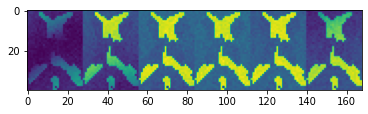

In [8]:
plt.imshow(img_train[2])

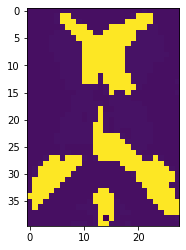

In [7]:
plt.imshow(gt_train[0])

In [107]:
# Define the network structure
inputs = tf.keras.Input(shape = (img_data.shape[1],img_data.shape[2]))

conv1 = tf.keras.layers.Conv1D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(inputs)
conv1 = tf.keras.layers.Conv1D(112, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv1)
pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv1)

conv2 = tf.keras.layers.Conv1D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool1)
conv2 = tf.keras.layers.Conv1D(56, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv2)
drop2 = tf.keras.layers.Dropout(0.5)(conv2)
pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)

conv3 = tf.keras.layers.Conv1D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(pool2)
conv3 = tf.keras.layers.Conv1D(14, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(conv3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)

up4 = tf.keras.layers.UpSampling1D(size = 2)(conv3)
deconv4 = tf.keras.layers.Conv1DTranspose(28, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(up4)

up5 = tf.keras.layers.UpSampling1D(size = 2)(deconv4)
deconv5 = tf.keras.layers.Conv1DTranspose(28, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform')(up5)

model = tf.keras.Model(inputs = inputs, outputs = deconv5)

print(model.summary())

Model: "functional_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 40, 168)]         0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 40, 112)           56560     
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 40, 112)           37744     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 20, 112)           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 20, 56)            18872     
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 20, 56)            9464      
_________________________________________________________________
dropout_112 (Dropout)        (None, 20, 56)          

In [108]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

# Starts training
history = model.fit(img_train, gt_train, epochs=50, batch_size=10, validation_split=0.1)  

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/50
81/81 [==============================] - 2s 20ms/step - loss: 0.1797 - mse: 0.1797 - val_loss: 0.1449 - val_mse: 0.1449
Epoch 2/50
81/81 [==============================] - 1s 11ms/step - loss: 0.1154 - mse: 0.1154 - val_loss: 0.1004 - val_mse: 0.1004
Epoch 3/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0902 - mse: 0.0902 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 4/50
81/81 [==============================] - 1s 11ms/step - loss: 0.0797 - mse: 0.0797 - val_loss: 0.0881 - val_mse: 0.0881
Epoch 5/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0781 - mse: 0.0781 - val_loss: 0.0868 - val_mse: 0.0868
Epoch 6/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0770 - mse: 0.0770 - val_loss: 0.0840 - val_mse: 0.0840
Epoch 7/50
81/81 [==============================] - 1s 10ms/step - loss: 0.0765 - mse: 0.0765 - val_loss: 0.0863 - val_mse: 0.0863
Epoch 8/50
81/81 [==============================] - 1s 11ms/step - loss: 0.0762 - m

In [109]:
# Save or load trained model 
model.save('image_regression'); 
#model = tf.keras.models.load_model('image_regression')

INFO:tensorflow:Assets written to: image_regression\assets


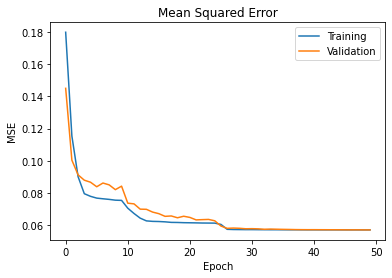

10/10 [==============================] - 0s 6ms/step - loss: 0.0573 - mse: 0.0573
Test MSE:0.057265


In [110]:
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(img_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

Text(0.5, 1.0, 'Residual Map')

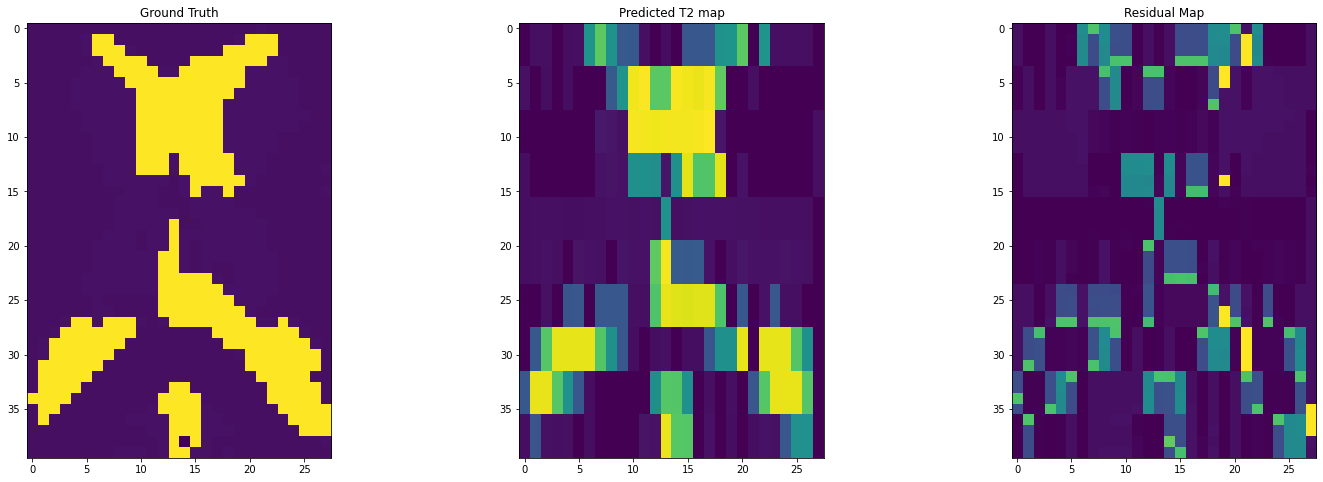

In [112]:
predicted_t2map = model.predict(img_test)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
ax1.imshow(gt_test[0])
ax1.set_title('Ground Truth')
ax2.imshow(predicted_t2map.mean(axis=0))
ax2.set_title('Predicted T2 map')
ax3.imshow(abs(gt_test[0]-predicted_t2map[0]))
ax3.set_title('Residual Map')